# Heart Disease Prediction using Random Forest Algorithm from scratch

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#for comparison with sklearn implementation.
from sklearn.tree import DecisionTreeClassifier

### Importing the Dataset

In [2]:
dataframe = pd.read_csv('../data/heart_disease_dataset_UCI.csv')

In [3]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Exploratory Data Analysis

#### Information on the features

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### finding the null values 

In [5]:
dataframe.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

#### mean of the entires across the features

In [6]:
dataframe.mean(axis = 0)

age          54.366337
sex           0.683168
cp            0.966997
trestbps    131.623762
chol        246.264026
fbs           0.148515
restecg       0.528053
thalach     149.646865
exang         0.326733
oldpeak       1.039604
slope         1.399340
ca            0.729373
thal          2.313531
target        0.544554
dtype: float64

#### Correlation matrix

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(dataframe.corr(), annot=True, cmap='terrain')

#### Pairplot of the entries 

In [8]:
sns.pairplot(data=dataframe)

#### box plot of the entries to check if normalization is required

In [9]:
dataframe.plot(kind='box', subplots=True, layout=(5,3), figsize=(12,12))
plt.show()

### Preprocessing

In [10]:
StandardScaler = StandardScaler()  
columns_to_scale = ['age','trestbps','chol','thalach','oldpeak']
dataframe[columns_to_scale] = StandardScaler.fit_transform(dataframe[columns_to_scale])

In [11]:
X = dataframe.iloc[:, :13].values
Y = dataframe.iloc[:, 13].values.reshape(-1,1)
dataframe[columns_to_scale] = StandardScaler.fit_transform(dataframe[columns_to_scale])
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)

### Source Code : Node Class

#### Node class has the following members
#### Value -> holds the predicted value for each entry. Its valid for the leaf nodes
#### threshold -> variable that helps decide in extending the tree at a node towards left or right. 
#### left_node -> left node for the current node
#### right_node -> right node for the current node
#### info_gain -> information gain at the current node. It is the difference in entropy from the parent node
#### feature_index -> index of the feature from the 12 existing features.

In [12]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left_node=None, right_node=None, info_gain=None, value=None):
        self.value = value
        self.feature_index = feature_index
        self.threshold = threshold
        self.left_node = left_node
        self.right_node = right_node
        self.info_gain = info_gain

### Source Code : MyDecisionTreeClassifier Class

#### root -> root node
#### max_depth -> hyperparameter that limits the maximum depth of the tree
#### min_split -> hyperparameter that decided the minimum split
#### fit() -> trains the model on the provided dataset
#### get_tree() -> called by the fit() and it generates the tree and returns the root node
#### get_best_split() -> returns the best split possible at a given node
#### information_gain() -> returns the gain in information based on the difference in entropy between its parent node and itself.
#### entropy() -> returns the current nodes entropy value
#### predict() -> performs prediction on the provided train set
#### single_prediction() -> called by predict() and it performs prediction for single entry


In [18]:
class MyDecisionTreeClassifier():
    def __init__(self, max_depth=2, min_split=2):
        self.root = None
        self.max_depth = max_depth
        self.min_split = min_split
        
    def fit(self, X, Y):
        data = np.concatenate((X, Y), axis=1)
        self.root = self.get_tree(data)
        
    def get_tree(self, data, curr_depth=0):
        X, Y = data[:,:13], data[:,13]
        num_entries, num_features = np.shape(X)
        
        if num_entries >= self.min_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(data, num_entries, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.get_tree(best_split["data_left"], curr_depth+1)
                right_subtree = self.get_tree(best_split["data_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        return Node(value = max(list(Y), key=list(Y).count))
    
    
    def get_best_split(self, data, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = data[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            for threshold in possible_thresholds:
                data_left = np.array([row for row in data if row[feature_index] <= threshold])
                data_right = np.array([row for row in data if row[feature_index] > threshold])
                
                if len(data_left) > 0 and len(data_right) > 0:
                    y, left_y, right_y = data[:, 13], data_left[:, 13], data_right[:, 13]
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["data_left"] = data_left
                        best_split["data_right"] = data_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split
    
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def predict(self, X):
        preditions = [self.single_prediction(x, self.root) for x in X]
        return preditions
    
    def single_prediction(self, x, tree):
        if tree.value != None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.single_prediction(x, tree.left_node)
        else:
            return self.single_prediction(x, tree.right_node)


In [14]:
print('mean values', np.mean(X_train, axis = 0))

mean values [-0.00930819  0.66079295  1.00440529 -0.05751397 -0.00586865  0.14537445
  0.52863436 -0.02212307  0.30837004  0.03120108  1.39207048  0.76651982
  2.29515419]


In [15]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    float64
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(5), int64(9)
memory usage: 33.3 KB


In [16]:
classifier = MyDecisionTreeClassifier(min_split=3, max_depth=5)
classifier.fit(X_train,Y_train)

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        35
           1       0.79      0.66      0.72        41

    accuracy                           0.72        76
   macro avg       0.73      0.73      0.72        76
weighted avg       0.74      0.72      0.72        76

Testing Accuracy for Decision Tree: 0.7236842105263158
Testing Sensitivity for Decision Tree: 0.6666666666666666
Testing Specificity for Decision Tree: 0.7941176470588235
Testing Precision for Decision Tree: 0.8


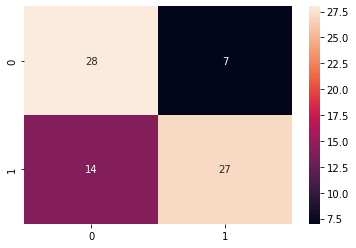

In [17]:
Y_pred = classifier.predict(X_test) 
accuracy_score(Y_test, Y_pred)
print(classification_report(Y_test,Y_pred))
cm = confusion_matrix(Y_test,Y_pred)
sns.heatmap(cm,annot=True)
TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]

print('Testing Accuracy for Decision Tree:',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Decision Tree:',(TP/(TP+FN)))
print('Testing Specificity for Decision Tree:',(TN/(TN+FP)))
print('Testing Precision for Decision Tree:',(TP/(TP+FP)))